In [1]:
import graph_tool as gt
import torch
import pickle
from src.diffusion_model_discrete import DiscreteDenoisingDiffusion
from sample import *
from src.diffusion import diffusion_utils
import networkx as nx
import matplotlib.pyplot as plt
from src.analysis.visualization import NonMolecularVisualization
import torch.nn.functional as F
import numpy as np

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::pair<double, double> already registered; second conversion method ignored.


In [2]:
model = get_model_facebook()
#visualizer = NonMolecularVisualization()


(ipykernel_launcher.py:229152): Gtk-WARNING **: 00:10:39.349: Locale not supported by C library.
	Using the fallback 'C' locale.


Marginal distribution of the classes: tensor([1.]) for nodes, tensor([0.7001, 0.2999]) for edges


/home/renyi/anaconda3/envs/digress/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [3]:
samples ,states = model.sample_batch_simplified("watermark",5)

100%|██████████| 5/5 [02:29<00:00, 29.95s/it]


In [4]:
states[0]

tensor([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2

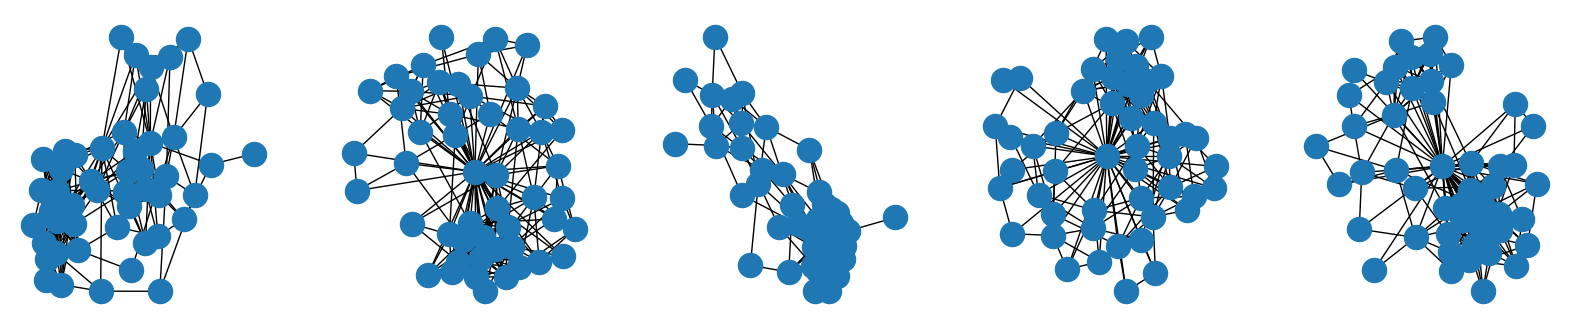

In [9]:
Es = [s[1].argmax(-1) for s in samples]
plt.subplots(1, 5, figsize=(20, 4))
for i, E in enumerate(Es):
    E_np = E.cpu().numpy()
    G = nx.from_numpy_matrix(E_np)
    pos = nx.spring_layout(G, seed=42)
    plt.subplot(1, 5, i+1)
    nx.draw(G, pos)

In [3]:
def flip_random_bit(gt_placeholder, bs = 1):
    # in place flip a random bit
    n = gt_placeholder.X.size(1)
    for t in range(bs):
        i = np.random.randint(0, n-1)
        j = np.random.randint(i+1, n)
       # print( gt_placeholder.E[0, i, j, : ], gt_placeholder.E[0, j, i, : ])
        gt_placeholder.E[0, i, j, : ] = 1 - gt_placeholder.E[0, i, j, :]
        gt_placeholder.E[0, j, i, : ] = 1 - gt_placeholder.E[0, j, i, :]
    return gt_placeholder


In [4]:
G_t = model.sample_G_T()
G_prime = model.sample_G_T()
#print(G_prime.X.size())
#print(G_t.X.size())
# assert not equal
#G_prime = flip_random_bit(G_prime)
assert not torch.equal(G_prime.E, G_t.E)

In [6]:
_, e1 = model.sample_one(G_t.copy(), deterministic=True)
_, e2 = model.sample_one(G_t.copy(), deterministic=True)

assert torch.equal(e2, e1)

In [11]:
def Jaccard_Similarity( e1, e2):
    intersection = np.sum(np.logical_and(e1, e2))
    union = np.sum(np.logical_or(e1, e2))
    if union == 0:  
        return 1.0 
    jaccard_similarity = intersection / union
    
    return jaccard_similarity

In [7]:
G_t = model.sample_G_T()
n = G_t.get_node_amount()
G_prime = model.sample_G_T(n_nodes=torch.tensor([n]))
G_prime.E = torch.tensor([1, 0]).repeat(n, n , 1).unsqueeze(0).to('cuda')
print("source diff:", torch.sum(torch.abs(G_prime.E - G_t.E)))

source diff: tensor(2142., device='cuda:0')


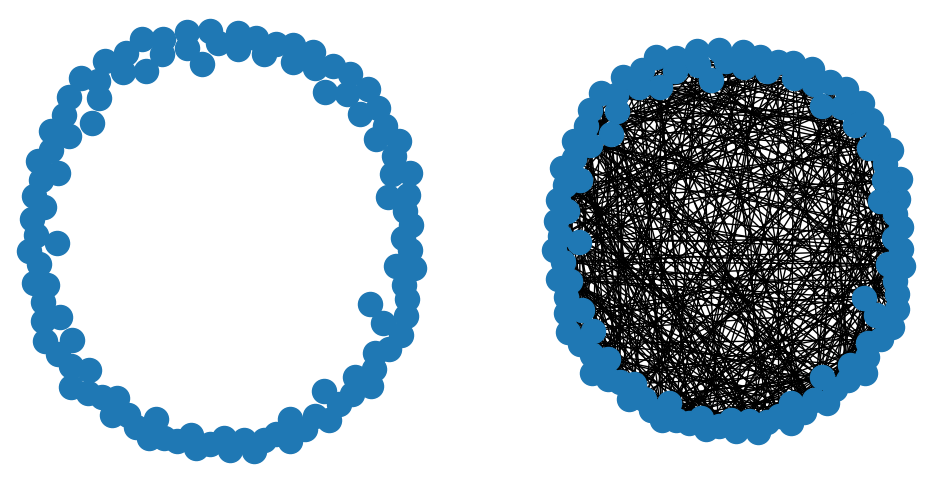

In [8]:
G1 = nx.from_numpy_matrix(G_prime.E.cpu().argmax(-1).numpy().squeeze(0))
pos = nx.spring_layout(G1, seed=42)
G2 = nx.from_numpy_matrix(G_t.E.cpu().argmax(-1).numpy().squeeze(0))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
nx.draw(G1, pos, ax=axes[0])
nx.draw(G2, pos, ax=axes[1])

In [10]:

G_0_np = model.sample_one(G_t.copy(), deterministic=True)[1].squeeze(0).numpy()
G_0_prime_np = model.sample_one(G_prime.copy(), deterministic=True)[1].squeeze(0).numpy()
print("target diff: ", np.sum(np.abs(G_0_prime_np - G_0_np)))


target diff:  0


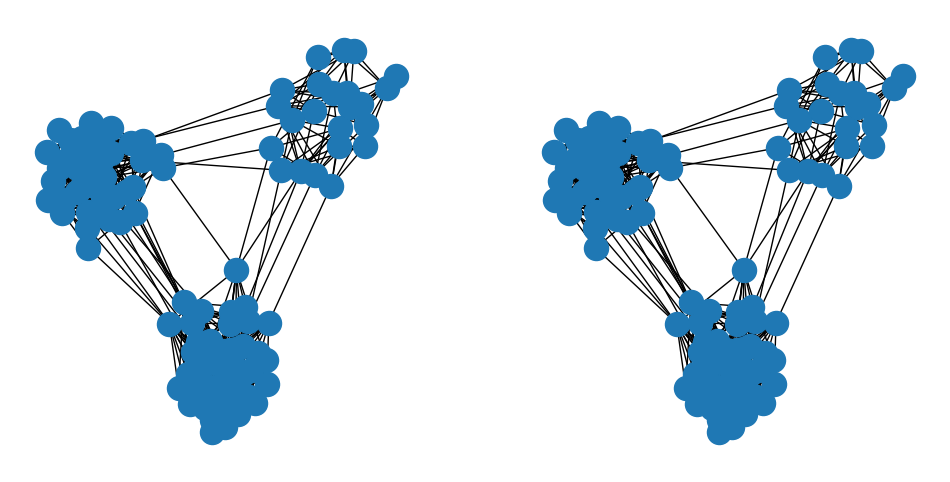

In [12]:

G1 = nx.from_numpy_matrix(G_0_np)
pos = nx.spring_layout(G1, seed=42)
G2 = nx.from_numpy_matrix(G_0_prime_np)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
nx.draw(G1, pos, ax=axes[0])
nx.draw(G2, pos, ax=axes[1])

source diff: tensor(3888., device='cuda:0')
target diff:  0
source diff: tensor(3992., device='cuda:0')
target diff:  0
source diff: tensor(3756., device='cuda:0')
target diff:  0


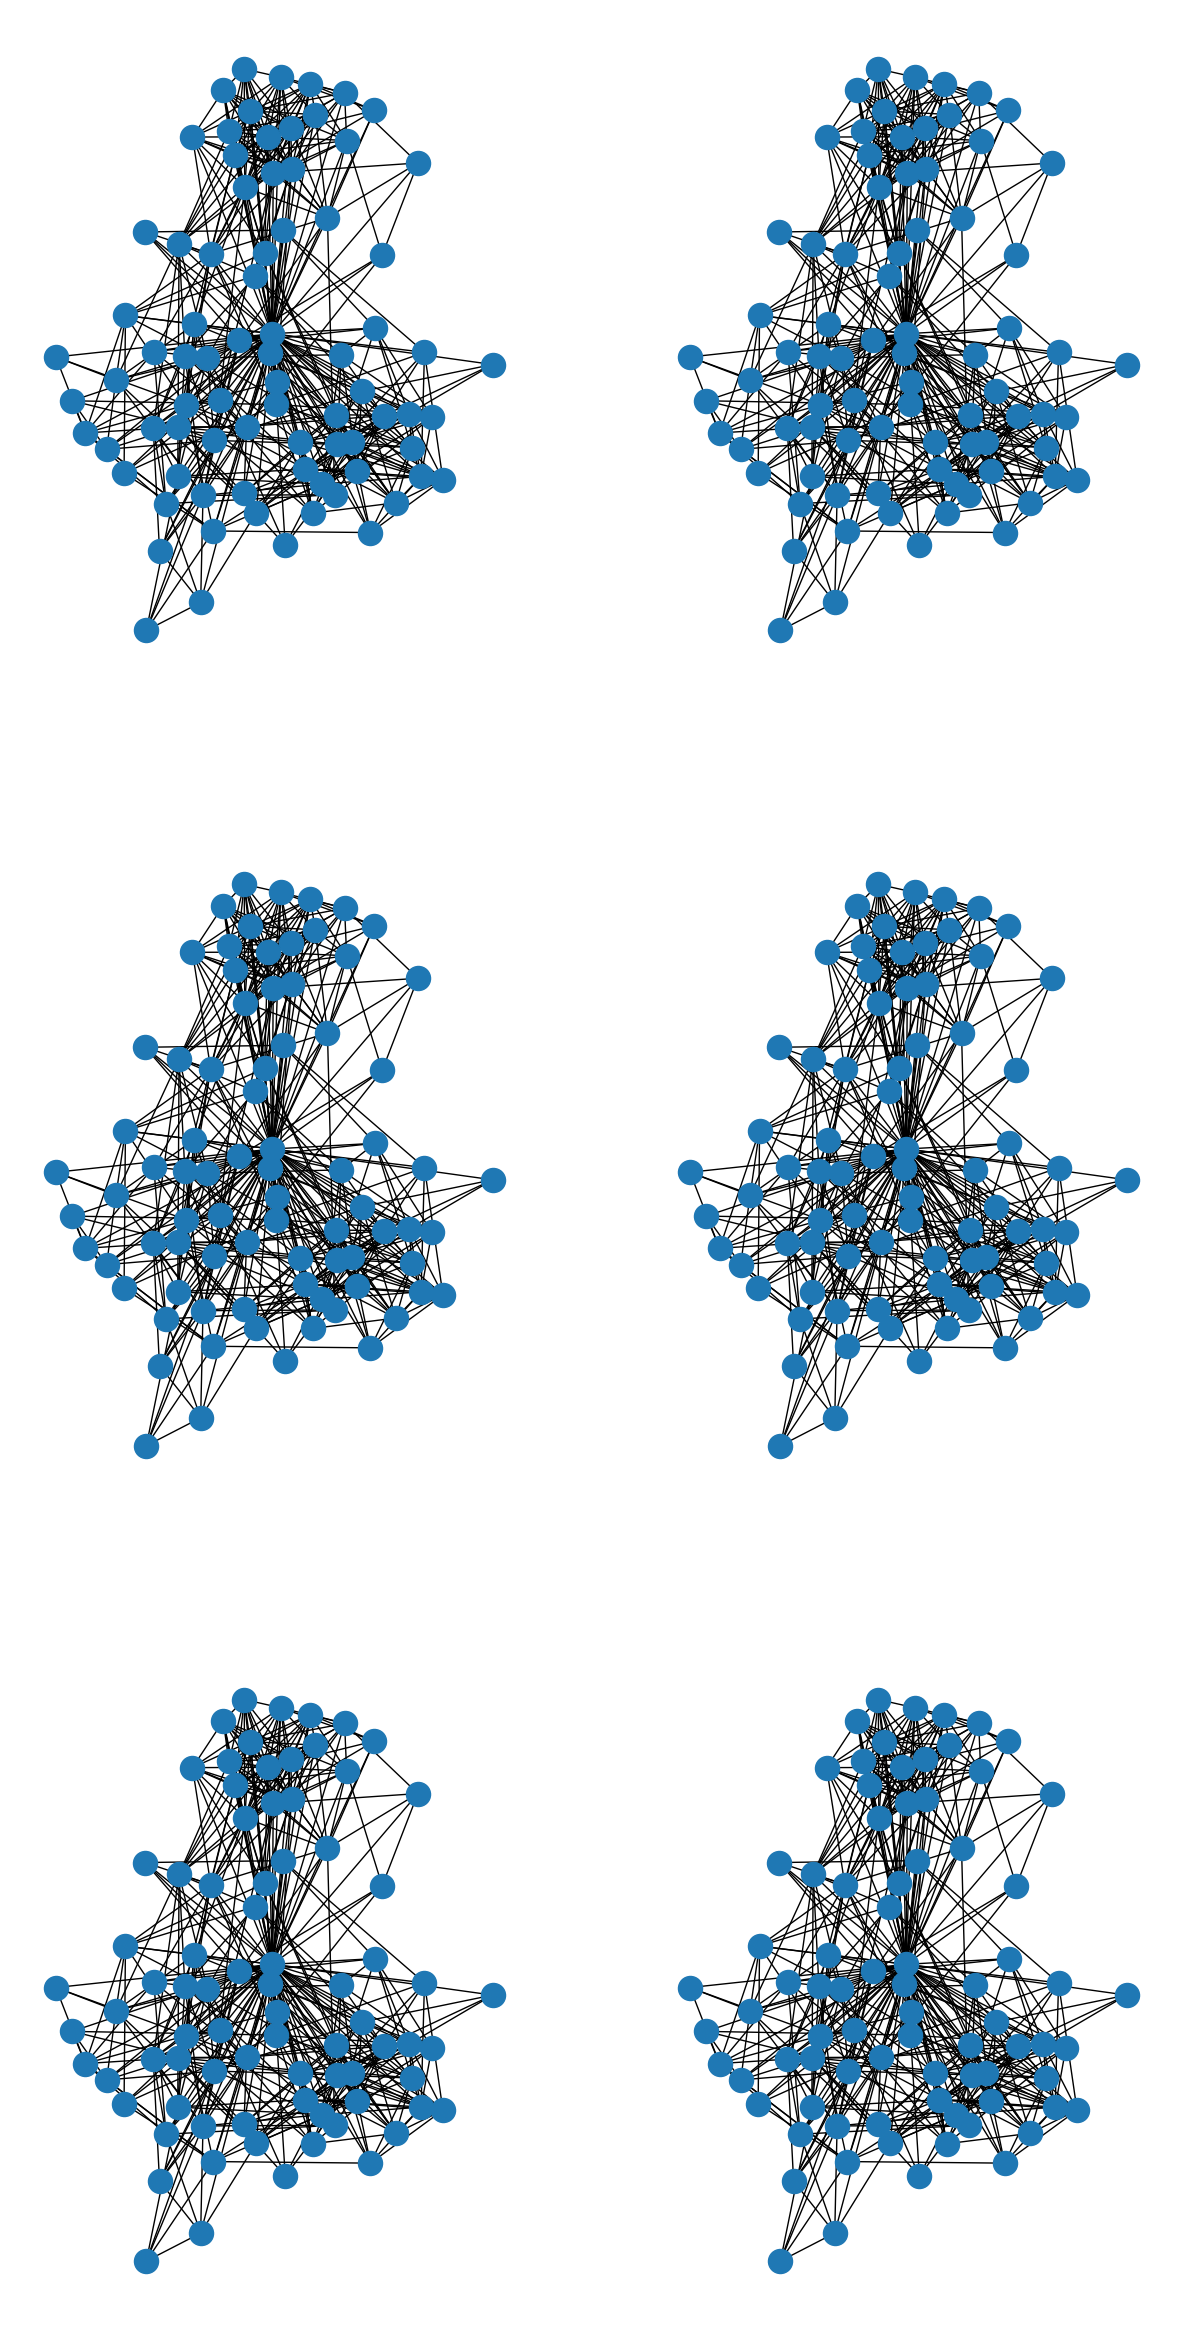

In [3]:
iter = 3
fig, axes = plt.subplots(iter, 2, figsize=(15, 30))
axes = axes.flatten() 
n = 80
for i in range(iter):
    G_t = model.sample_G_T(n_nodes=torch.tensor([n]))
    G_0_np = model.sample_one(G_t.copy(), deterministic=True)[1].squeeze(0).numpy()
    G_prime = model.sample_G_T(n_nodes=torch.tensor([n]))
    G_prime.E = torch.tensor([1, 0]).repeat(n, n , 1).unsqueeze(0).to('cuda')
    print("source diff:", torch.sum(torch.abs(G_prime.E - G_t.E)))
    G_0_prime_np = model.sample_one(G_prime.copy(), deterministic=True)[1].squeeze(0).numpy()
    #print(G_0_prime_np.shape, G_0_np.shape)
    print("target diff: ", np.sum(np.abs(G_0_prime_np - G_0_np)))
    G_0 = nx.from_numpy_matrix(G_0_np)
    G_0_prime = nx.from_numpy_matrix(G_0_prime_np)
    pos1 = nx.spring_layout(G_0, seed=42)
    pos2 = nx.spring_layout(G_0_prime, seed=42)
    nx.draw(G_0, pos1, ax=axes[2*i])
    nx.draw(G_0_prime, pos2, ax=axes[2*i + 1])

In [22]:
str = "watermark"
hash(str)


-2315057986869137212

In [24]:
local_gen = torch.Generator()
local_gen.manual_seed(hash(str))
# generate some values
local_gen.

AttributeError: 'torch._C.Generator' object has no attribute 'randint'